# Echo chambers

Find groups of users which often send out the same tweets

In [1]:
import os
import pandas as pd
import re
import sys

from IPython.display import clear_output

In [2]:
DATADIR = "../data/text/"

In [3]:
def squeal(text=None):
    clear_output(wait=True)
    if not text is None: print(text)

def remove_url_suffix(tweet):
    return(re.sub("\s*https?://.*$","",tweet,flags=re.IGNORECASE))

def remove_rt_prefix(tweet):
    return(re.sub("^RT[^:]*:\s*","",tweet))

def read_tweets(file_pattern):
    files = os.listdir(DATADIR)
    users_per_tweet = {}
    tweets_per_user = {}
    nbr_of_tweets = 0
    for file_name in files:
        if re.search(file_pattern,file_name):
            df = pd.read_csv(DATADIR+file_name)
            nbr_of_tweets += len(df)
            for i in range(0,len(df)):
                user = df.iloc[i]["user"]
                text = remove_rt_prefix(remove_url_suffix(df.iloc[i]["text"])).strip()
                if not text in users_per_tweet: users_per_tweet[text] = [user]
                elif not user in users_per_tweet[text]: users_per_tweet[text].append(user)
                if not user in tweets_per_user: tweets_per_user[user] = 1
                else: tweets_per_user[user] += 1
    return(users_per_tweet,tweets_per_user,nbr_of_tweets)

In [4]:
def get_user_pairs(users_per_tweet):
    user_pairs = {}
    for user_group in users_per_tweet.values():
        for i in range(1,len(user_group)):
            for j in range(i+1,len(user_group)):
                pair = " ".join([user_group[i],user_group[j]])
                if not pair in user_pairs: user_pairs[pair] = 1
                else: user_pairs[pair] += 1
    return(user_pairs)

In [5]:
def show_top_user_pairs(user_pairs):
    for pair in sorted(user_pairs.keys(),key=lambda p:user_pairs[p],reverse=True)[:20]:
        print(f"{user_pairs[pair]} {pair}")
    return()

In [6]:
THRESHOLD = 10

def make_user_groups(user_pairs):
    user_groups = {}
    for pair in user_pairs:
        if user_pairs[pair] >= THRESHOLD:
            user1,user2 = pair.split()
            if not user1 in user_groups and not user2 in user_groups:
                user_groups[user1] = (user1,user2)
                user_groups[user2] = (user1,user2)
            elif user1 in user_groups and not user2 in user_groups:
                user_groups[user1] = tuple(set(user_groups[user1]+(user2,)))
                for e in user_groups[user1]: user_groups[e] = user_groups[user1]
                user_groups[user2] = user_groups[user1]
            elif not user1 in user_groups and user2 in user_groups:
                user_groups[user2] = tuple(set(user_groups[user2]+(user1,)))
                for e in user_groups[user2]: user_groups[e] = user_groups[user2]
                user_groups[user1] = user_groups[user2]
            else:
                user_groups[user1] = tuple(set(user_groups[user1]+user_groups[user2]))
                for e in user_groups[user1]: user_groups[e] = user_groups[user1]
                for e in user_groups[user2]: user_groups[e] = user_groups[user1]
    return(user_groups)

In [7]:
def show_user_groups(user_groups):
    seen = {}
    for user in user_groups:
        if not user in seen:
            print(len(user_groups[user]),[u for u in sorted(user_groups[user],key=lambda u:u.lower())])
            for u in user_groups[user]: seen[u] = True

In [8]:
def get_largest_group(user_groups):
    largest_group = []
    for user in user_groups:
        if len(user_groups[user]) > len(largest_group): 
            largest_group = user_groups[user]
    return(largest_group)

def compute_overlap(group1,group2):
    return(len(set(group1) & set(group2)))

def get_nbr_of_tweets(user_group,tweets_per_user):
    nbr_of_tweets = 0
    for user in user_group: nbr_of_tweets += tweets_per_user[user]
    return(nbr_of_tweets)

In [16]:
OUTFILENAME = "echo-chambers.txt"

previous_user_group = []
last_seen = {}
for month in range(202005,202006):
    for day in range(4,5):
        date = str(month)+str(day).zfill(2)
        users_per_tweet,tweets_per_user,nbr_of_tweets = read_tweets(date)
        if nbr_of_tweets == 0: continue
        user_pairs = get_user_pairs(users_per_tweet)
        user_groups = make_user_groups(user_pairs)
        largest_user_group = get_largest_group(user_groups)
        largest_user_group_tweet_count = get_nbr_of_tweets(largest_user_group,tweets_per_user)
        if len(previous_user_group) == 0:
            print(date,len(largest_user_group),0,largest_user_group_tweet_count,nbr_of_tweets,sep=",")
        else:
            print(date,len(largest_user_group),compute_overlap(previous_user_group,largest_user_group),
                  largest_user_group_tweet_count,nbr_of_tweets,sep=",")
        for user in largest_user_group: last_seen[user] = date
        #out_file = open(OUTFILENAME,"a")
        #print(date,nbr_of_tweets,largest_user_group_tweet_count,largest_user_group,file=out_file)
        #out_file.close()
        previous_user_group = largest_user_group

20200504,274,0,39057,645085


In [1]:
show_user_groups(user_groups)

In [11]:
last_seen_dates = {}
for user in last_seen:
    date = last_seen[user]
    if not date in last_seen_dates: last_seen_dates[date] = 1
    else: last_seen_dates[date] += 1
[(last_seen_dates[date],date) for date in sorted(last_seen_dates.keys(),key=lambda d:last_seen_dates[d],reverse=True)][:10]

[(272, '20201031'),
 (192, '20201020'),
 (141, '20201030'),
 (134, '20201029'),
 (112, '20201017'),
 (101, '20201019'),
 (101, '20201013'),
 (94, '20201016'),
 (83, '20201021'),
 (83, '20201018')]

In [12]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
DATEFORMAT = "%Y%m%d"

In [14]:
df = pd.read_csv("echo-chambers.csv",index_col="date")

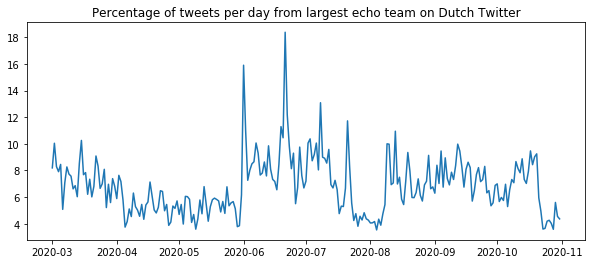

In [15]:
PLOTFILENAME = "echo-chambers.png"

plt.subplots(figsize=(10,4))
plt.plot_date([datetime.datetime.strptime(str(d),DATEFORMAT) for d in df.index],
              [100*df.iloc[d]["group_tweets"]/df.iloc[d]["all_tweets"] for d in range(0,len(df))],
              xdate=True,fmt="-")
plt.title("Percentage of tweets per day from largest echo team on Dutch Twitter")
plt.savefig(PLOTFILENAME)
plt.show()